### Libs preparation

In [25]:
import sys
import os

sys.path.append('..')

# **Questão 1**

Bibliotecas

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Tratamento dos dados

In [27]:
from amaprob.preprocessing.polynomial_features import PolynomialFeatures

data = pd.read_csv('../data/linear_regression_data.csv', header=None)
poly_1 = PolynomialFeatures(1)  # Aplicar atributos polinomiais com grau 1 retorna os dados com a primeira coluna constante

X = np.array([data.values[:, 0]]).T
X_processed = poly_1.transform(X)
y = np.array([data.values[:, 1]]).T

Definição do modelo, considerando as prioris sendo a média um vetor de zeros e a covariância uma matriz identidade, e assumindo um ruído gaussiano de valor $\sigma^2 = 0.5$

In [28]:
from amaprob.models.bayesian_linear_regression import BayesianLinearRegression

mean_prior = np.array([np.zeros(2)]).T
cov_prior = np.identity(2)

model = BayesianLinearRegression(mean_prior, cov_prior, noise=0.5)

Plotando o modelo "dummy"

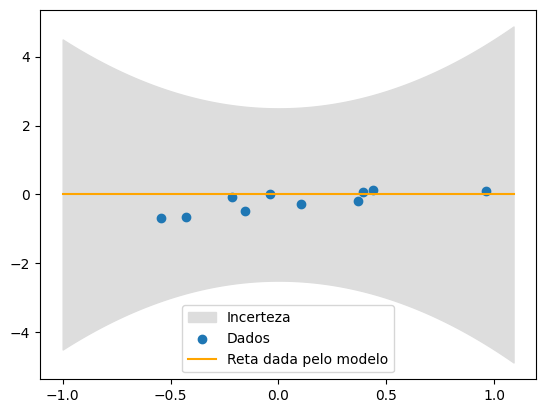

In [29]:
rng = np.arange(-1.0, 1.1, 0.01)
rng_processed = poly_1.transform(np.array([rng]).T)

predictions = model.predict(rng_processed)
upper_bound = predictions + 2*model.get_std(rng_processed)
lower_bound = predictions - 2*model.get_std(rng_processed)

plt.fill_between(rng, upper_bound.T[0], lower_bound.T[0], color='#dddddd')
plt.scatter(X, y)
plt.plot(rng, predictions, color='orange')
plt.legend(['Incerteza', 'Dados', 'Reta dada pelo modelo'])

Atualizando o modelo

In [30]:
model.update(X_processed, y)

Plotando o modelo após a atualização

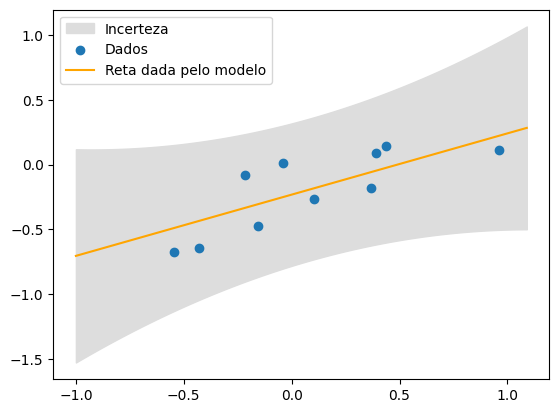

In [31]:
rng = np.arange(-1.0, 1.1, 0.01)
rng_processed = poly_1.transform(np.array([rng]).T)

predictions = model.predict(rng_processed)
upper_bound = predictions + 2*model.get_std(rng_processed)
lower_bound = predictions - 2*model.get_std(rng_processed)

plt.fill_between(rng, upper_bound.T[0], lower_bound.T[0], color='#dddddd')
plt.scatter(X, y)
plt.plot(rng, predictions, color='orange')
plt.legend(['Incerteza', 'Dados', 'Reta dada pelo modelo'])

# **Questão 2**

Tratamento dos dados

In [32]:
data = pd.read_csv('../data/polynomial_regression_data.csv', header=None)
poly_5 = PolynomialFeatures(5)

X = np.array([data.values[:, 0]]).T
X_processed = poly_5.transform(X)
y = np.array([data.values[:, 1]]).T

Definição do modelo, considerando as prioris sendo a média um vetor de zeros e a covariância uma matriz identidade, e assumindo um ruído gaussiano de valor $\sigma^2 = 1$

In [33]:
mean_prior = np.array([np.zeros(6)]).T
cov_prior = np.identity(6)

model = BayesianLinearRegression(mean_prior, cov_prior)

Plotando o modelo "dummy"

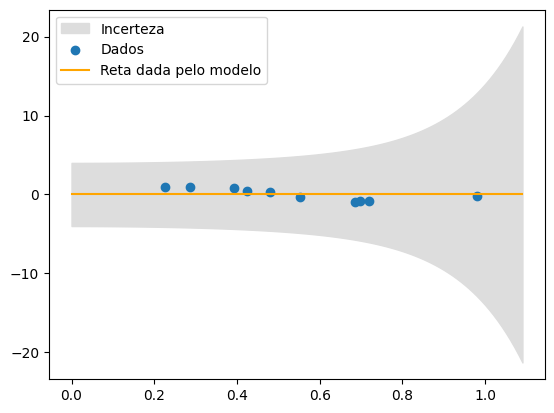

In [34]:
rng = np.arange(0.0, 1.1, 0.01)
rng_processed = poly_5.transform(np.array([rng]).T)

predictions = model.predict(rng_processed)
upper_bound = predictions + 2*model.get_std(rng_processed)
lower_bound = predictions - 2*model.get_std(rng_processed)

plt.fill_between(rng, upper_bound.T[0], lower_bound.T[0], color='#dddddd')
plt.scatter(X, y)
plt.plot(rng, predictions, color='orange')
plt.legend(['Incerteza', 'Dados', 'Reta dada pelo modelo'])

Atualizando o modelo

In [35]:
model.update(X_processed, y)

Plotando o modelo após a atualização

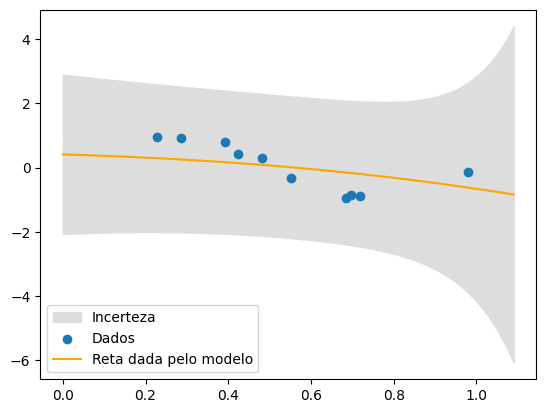

In [36]:
rng = np.arange(0.0, 1.1, 0.01)
rng_processed = poly_5.transform(np.array([rng]).T)

predictions = model.predict(rng_processed)
upper_bound = predictions + 2*model.get_std(rng_processed)
lower_bound = predictions - 2*model.get_std(rng_processed)

plt.fill_between(rng, upper_bound.T[0], lower_bound.T[0], color='#dddddd')
plt.scatter(X, y)
plt.plot(rng, predictions, color='orange')
plt.legend(['Incerteza', 'Dados', 'Reta dada pelo modelo'])